# Python On Resonance (PyOR)
## Everybody can simulate NMR

Author: Vineeth Thalakottoor 

Email: vineethfrancis.physics@gmail.com

## Tutorial 5: Evolution of Density Matrix in Hilbert Space Part 1
In previous tutorial, we saw how to generate initial density matrix for two spin system a electron and a proton at thermal equlibrium. In this tutorial we try to evolve the density matrix in time by solving Liouville-Von Neumann equation in Hilbert Space for a single spin half system

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [67]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_G/Source'

In [68]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *

## Generating Spin System

In [69]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2]

In [70]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [71]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

## Zeeman Hamiltonian in Lab Frame

In [72]:
"""
Gyromagnetic Ratio
Gamma = [Gyromagnetic Ratio spin 1, Gyromagnetic Ratio spin 1, ...]
""";
Gamma = [System.gammaH1]

"""
Define the field of the spectromter, B0 in Tesla.
"""
B0 = 9.4

"""
Define the chemical Shift of individual spins
Offset = [chemical Shift spin 1, chemical Shift spin 1, ..]
"""
Offset = [20] # Offset frequency in Hz

"""
Function "LarmorF" give the list Larmor frequencies of individual spins in lab frame
"""
LarmorF = System.LarmorFrequency(Gamma,B0,Offset)

Hz = System.Zeeman(LarmorF,Sz)

Larmor Frequency in MHz:  [-400.22803765]


## Initialize Density Matrix

In [73]:
"""
We will generate Initial Density Matrix in two ways: 
First we will generate a density matrix as we prefer say, Sz. 
Second we will create density matrix at thermal equlibrium

First Case
""";

Thermal_DensMatrix = False 

if Thermal_DensMatrix:
    Hz_EnUnit = System.Convert_FreqUnitsTOEnergy(Hz)
    HT_approx = False # High Temperature Approximation is False
    T = 300 # Temperature in Kelvin
    rho_in = System.EqulibriumDensityMatrix(Hz_EnUnit,T,HT_approx)
    rhoeq = rho_in.copy()   
else:
    rho_in = np.sum(Sz,axis=0) # Initial Density Matrix
    rhoeq = np.sum(Sz,axis=0)  # Equlibrium Density Matrix   
    print("Trace of density metrix = ", np.trace(rho_in))

Trace of density metrix =  0j


In [74]:
Matrix(rho_in)

Matrix([
[0.5,    0],
[  0, -0.5]])

<IPython.core.display.Javascript object>


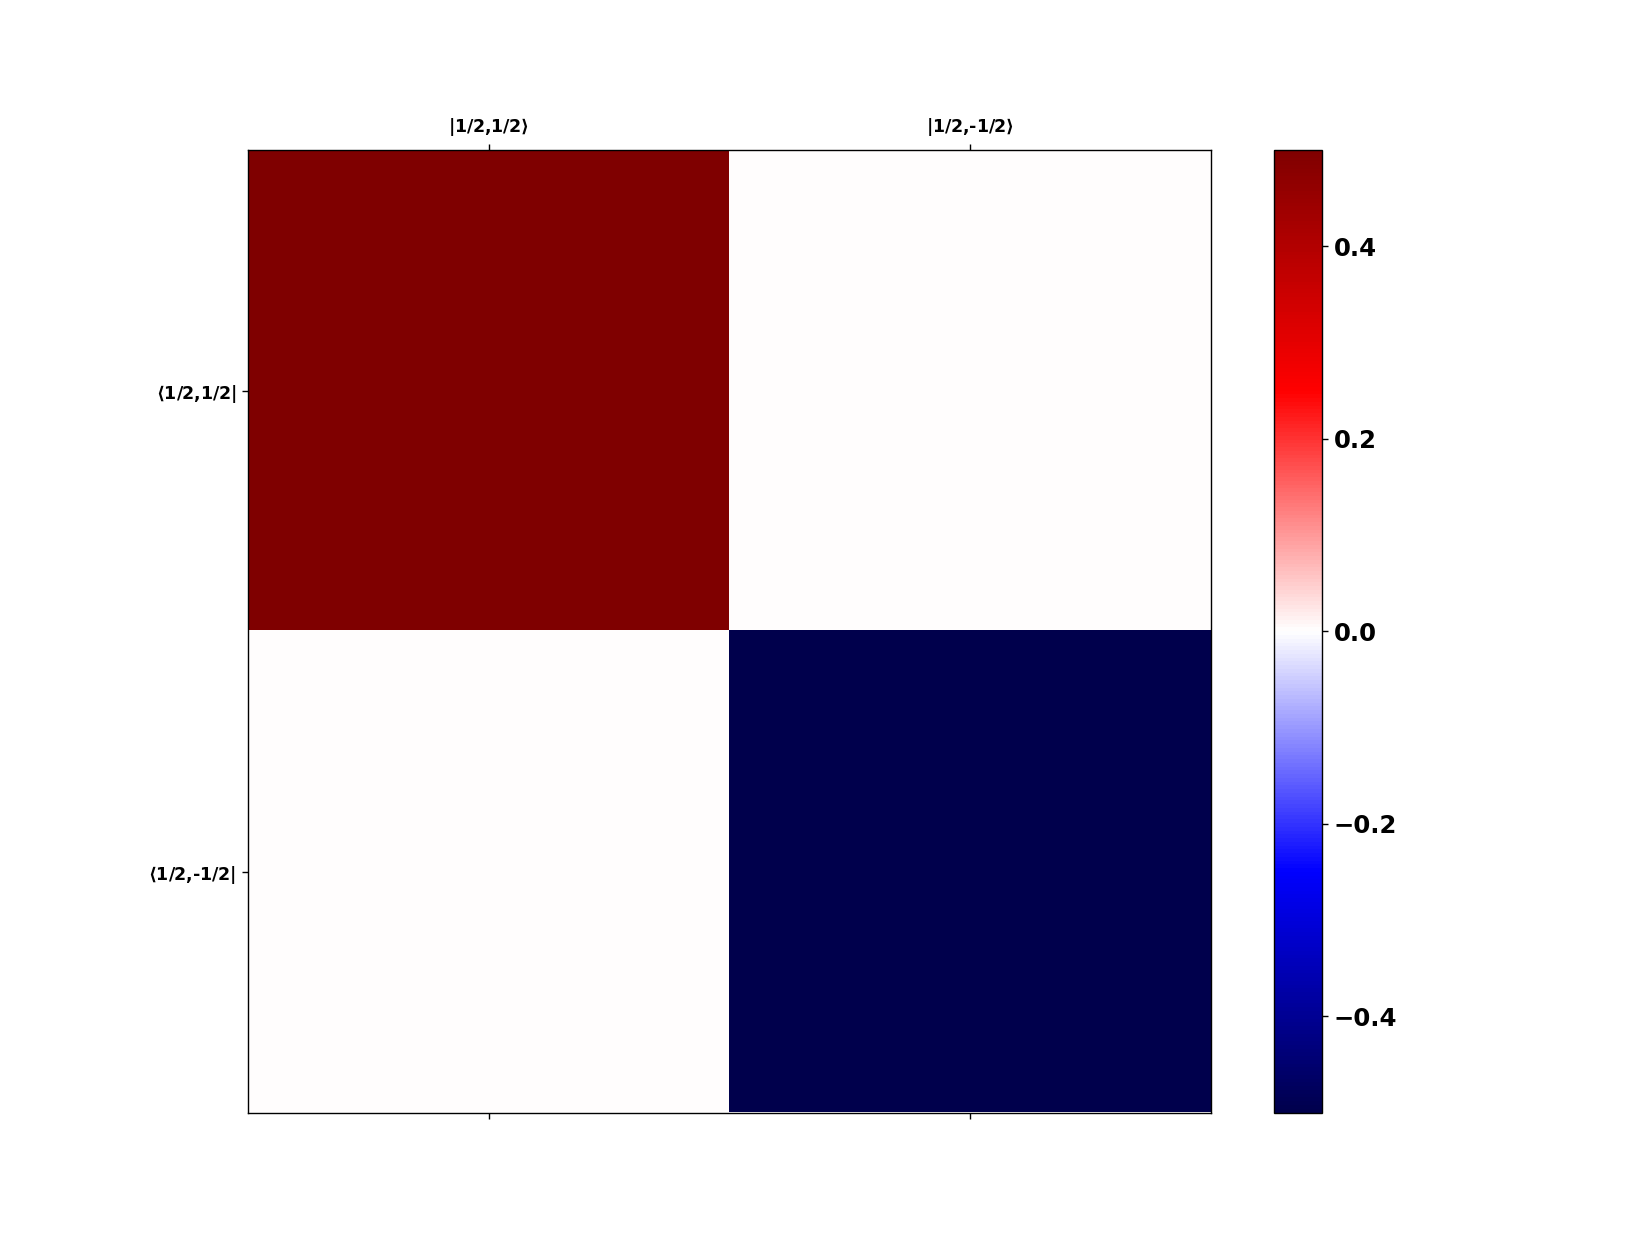

/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_G/Source/PythonOnResonance.py:669: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labelx,fontsize=10)
/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_G/Source/PythonOnResonance.py:670: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labely,fontsize=10)


In [75]:
System.MatrixPlot(1,rho_in.real)

## Zeeman Halitonian in Rotating Frame

In [76]:
OmegaRF = [-System.gammaH1*B0]
Hzr = System.Zeeman_RotFrame(LarmorF, Sz, OmegaRF)

## Pulse

In [77]:
"""
Rotate the magnetization about Y-axis, by an angle theta.
""";
pulse_angle = 90.0
rho = System.Rotate_H(rho_in,pulse_angle,np.sum(Sy,axis=0)) 

<IPython.core.display.Javascript object>


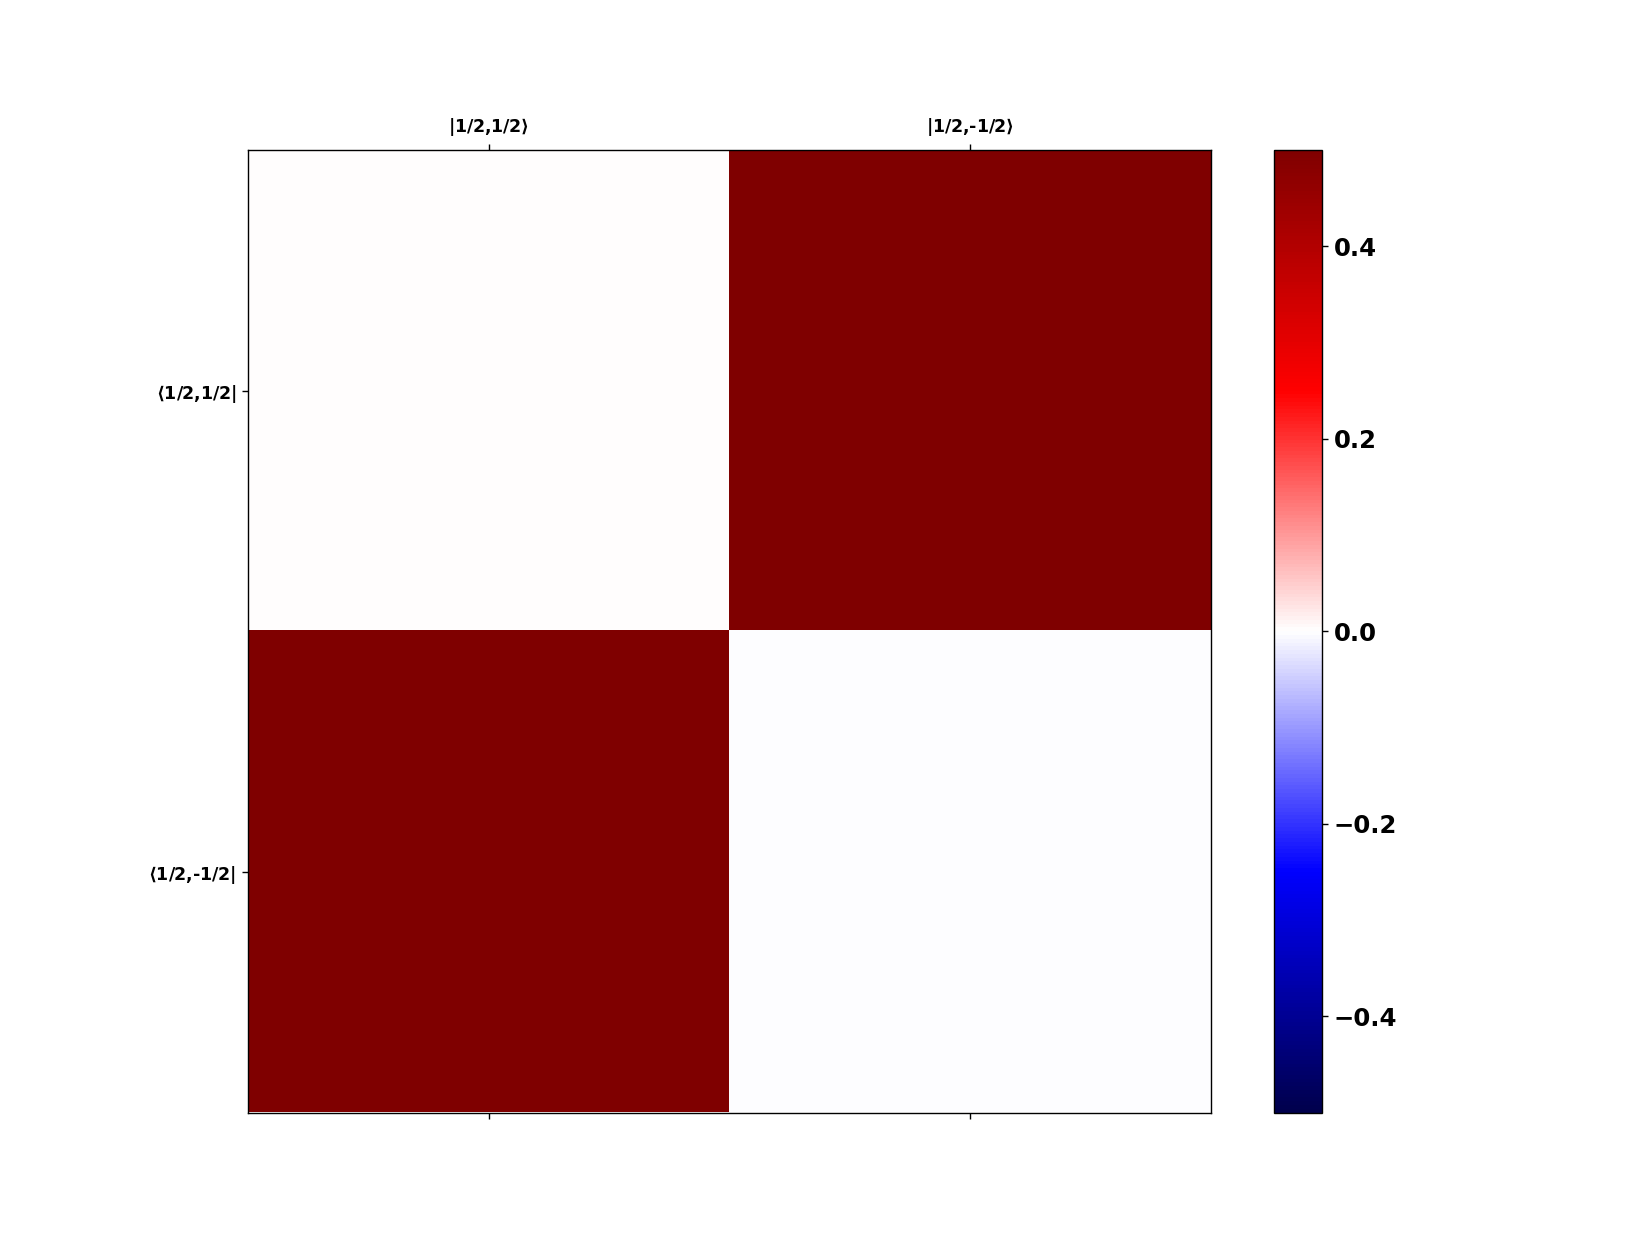

In [78]:
System.MatrixPlot(2,rho.real)

## Relaxation Constant

In [79]:
'''
Define longitudinal (R1) and transverse Relaxation (R2)
R1 = [R1 of first spin, R1 of second spin,...]
R2 = [R2 of first spin, R2 of second spin,...]
''';

R1 = np.asarray([0])
R2 = np.asarray([0])
System.Relaxation_Constants(R1,R2)

'''
Options for "Rprocess": "No Relaxation" or "Phenomenological" 
                         or "Random Field Fluxtuation" or "Dipolar"
''';
Rprocess = "No Relaxation"

## Evolution of Density Matrix

In [80]:
"""
Samplling Rate, fs = n * Highest_Larmor_Frequency; minimum value of n = 2 (Nyquist–Shannon sampling theorem)
Dwell time, dt = 1/fs
Acquisition time, AQ is time for which we evolve the density matrix, in seconds.
Number of points in the simulation, Npoints
""";
Highest_Larmor_Frequency = 20.0
fs = 4 * Highest_Larmor_Frequency
dt = 1.0/fs
AQ = 5.0
Npoints = int(AQ/dt)
print("Number of points in the simulation", Npoints)

"""
option for solver, "method": "Unitary Propagator" or "ODE Solver"
"""
method = "Unitary Propagator"

start_time = time.time()
t, rho_t = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Hzr,dt,Npoints,method,Rprocess)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Number of points in the simulation 400
Total time = 0.0039899349212646484 seconds 


## Expectation value

In [81]:
"""
Basis Operators in plus minus Z 
""";
Basis = "PMZ spin half"
B_PMZ = System.SingleSpinOP(Sx,Sy,Sz,Sp,Sm,Basis)

<IPython.core.display.Latex object>

In [82]:
"""
Lets see the expectation value of I+
""";

t, Mp = System.Expectation_H(rho_t,B_PMZ[1],dt,Npoints)

## Windowing

In [83]:
Mp = System.WindowFunction(t,Mp,5.0)

## Fourier Transform

In [84]:
fs = 1.0/dt
freq, spectrum = System.FourierTransform(Mp,fs,5)

## Plotting

<IPython.core.display.Javascript object>


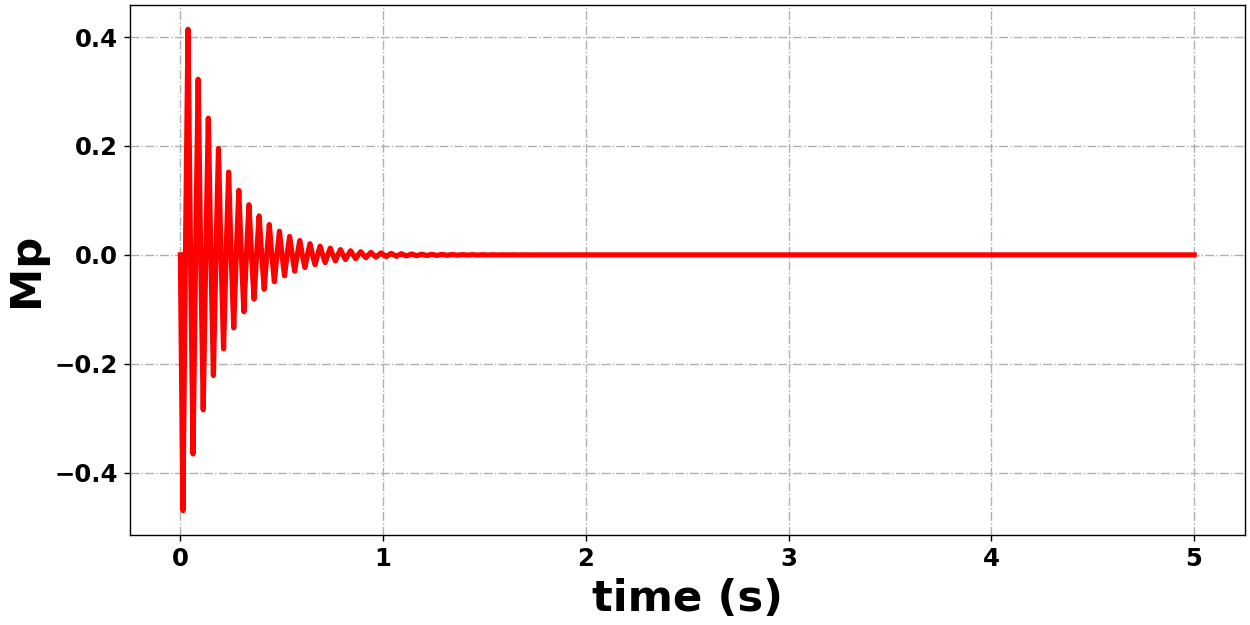

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [85]:
System.Plotting(3,t,Mp,"time (s)","Mp","red")

<IPython.core.display.Javascript object>


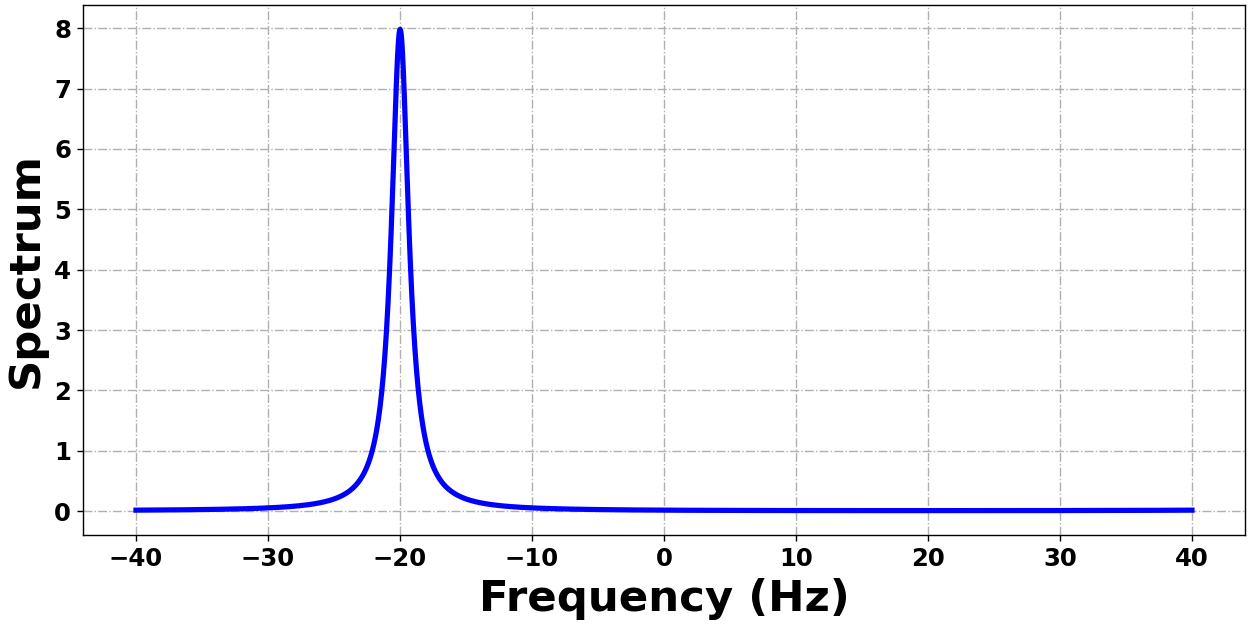

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [86]:
PH0 = 45.0
spectrum_PH0 = System.PhaseAdjust_PH0(spectrum,PH0)
System.Plotting(4,freq,spectrum_PH0,"Frequency (Hz)","Spectrum","blue")

## Next tutorial: Evolution of Density Matrix in Hilbert Space Part 2
In this lecture you will see how to evolve the desnity matrix in time by solving Liouville-Von Neumann equation in Hilbert Space for two spin half system.

## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free. 

vineethfrancis.physics@gmail.com